# Downloading data

In [ ]:
!gdown 1Dnrw8SG_bNHep1GEdasnVgg9ycg_8t2l


Downloading...
From: https://drive.google.com/uc?id=1Dnrw8SG_bNHep1GEdasnVgg9ycg_8t2l
To: /content/archive.zip
100% 102M/102M [00:00<00:00, 132MB/s] 


In [ ]:
!unzip "/content/archive.zip"

Archive:  /content/archive.zip
replace cats_dogs/cat_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace cats_dogs/cat_10.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Importing libraries

In [ ]:
# importing all the modules
import numpy
import pandas
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Splitting data

In [ ]:
DIR = "/content/cats_dogs"

train_dir=DIR+"/train"
test_dir=DIR+"/test"

In [ ]:
# get the train files
file_train_cat= tf.io.gfile.glob(train_dir + '/cat/*')
file_train_dog= tf.io.gfile.glob(train_dir+ '/dog/*')
#checking balance between dataset
print("size of cat training data",len(file_train_cat))
print("size of dog training data",len(file_train_dog))

size of cat training data 125
size of dog training data 85


In [ ]:
# slicing cat training dataset so we could achieve balance
file_train_cat = file_train_cat[:len(file_train_dog)]

print("size of cat training data",len(file_train_cat))

size of cat training data 85


In [ ]:
#combine
file_train_cat.extend(file_train_dog)
# shuffle
train_ds = tf.random.shuffle(file_train_cat)

# get the test files
file_test = tf.io.gfile.glob(test_dir + '/*/*')
# shuffle
file_test = tf.random.shuffle(file_test)
test_ds=file_test


# Function for making and preprocessing tensors out of Audio file

In [ ]:
def getWaveform(file):
  label = tf.strings.split(file, os.path.sep)[-2]
  audio_binary = tf.io.read_file(file)
  audio, _ = tf.audio.decode_wav(audio_binary)
  waveform=tf.squeeze(audio, axis=-1)
  return waveform, label

AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(getWaveform, num_parallel_calls=AUTO)

# Creating spectrogram that will be used as input in model

In [ ]:
def get_spectrogram_label(audio, label):
  # apply padding
  padding = tf.zeros([300000] - tf.shape(audio), dtype=tf.float32)
  # get the spectogram of the audio
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(
      eq_length, frame_length=210, frame_step=110)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # get associated label of the audio
  label_id = tf.argmax(label == labels)
  # return the spectogram and the label
  return spectrogram, label_id

# get all the labels from the dataset
labels = np.array(["cat","dog"])

# get the labels and spectogram
spectrogram_ds = waveform_ds.map(
    get_spectrogram_label, num_parallel_calls=AUTO)

# Preprocessing data using the previous functions

In [ ]:
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  # get waveforms and labels
  output_ds = files_ds.map(getWaveform, num_parallel_calls=AUTO)
  # get spectogram and labels
  output_ds = output_ds.map(
      get_spectrogram_label,  num_parallel_calls=AUTO)
 # return the data
  return output_ds

# train test and validate data
train_ds = spectrogram_ds

test_ds = preprocess(test_ds)

# Intiating data into Batches

In [ ]:
batch_size = 64
# batch train and validate data
train_ds = train_ds.batch(batch_size)
# cache and prefetch the data
train_ds = train_ds.cache().prefetch(AUTO)

x = train_ds

# Building Model

In [276]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)
# normalize adapt
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# adding layers
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
model.summary()

Input shape: (2726, 129, 1)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_22 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_22 (Normaliz  (None, 32, 32, 1)         3         
 ation)                                                          
                                                                 
 conv2d_176 (Conv2D)         (None, 30, 30, 32)        320       
                                                                 
 conv2d_177 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 conv2d_178 (Conv2D)         (None, 26, 26, 32)        9248      
                                                                 
 conv2d_179 (Conv2D)         (None, 24, 24, 32)        9248      
                         

# Training Model

In [277]:
EPOCHS = 500
history = model.fit(
    train_ds,
    epochs=EPOCHS,
)

Epoch 1/500
3/3 [==============================] - 3s 25ms/step - loss: 0.6927 - accuracy: 0.5471
Epoch 2/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6936 - accuracy: 0.4882
Epoch 3/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6937 - accuracy: 0.5235
Epoch 4/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6938 - accuracy: 0.4529
Epoch 5/500
3/3 [==============================] - 0s 21ms/step - loss: 0.6933 - accuracy: 0.4765
Epoch 6/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6923 - accuracy: 0.5353
Epoch 7/500
3/3 [==============================] - 0s 21ms/step - loss: 0.6930 - accuracy: 0.4941
Epoch 8/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6933 - accuracy: 0.5412
Epoch 9/500
3/3 [==============================] - 0s 19ms/step - loss: 0.6931 - accuracy: 0.5176
Epoch 10/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6934 - accuracy: 0.4882
Epoch 11/500
3/3 [=

# Calculating Accuracy and creating Confusion Matrix

In [278]:
# initialize empty list to save the audio and labels
t_audio = []
t_labels = []

# load in the labels and audio from test dataset
for audio, label in test_ds:
  t_audio.append(audio.numpy())
  t_labels.append(label.numpy())

# convert the lists to a numpy array
t_audio = np.array(t_audio)
t_labels = np.array(t_labels)

In [279]:
# Feed in the data for prediction
y_pred = np.argmax(model.predict(t_audio), axis=1)

# store the original labels for testing the accuracy
y_true = t_labels

# get the testing accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 [==============================] - 0s 10ms/step
Test set accuracy: 85%


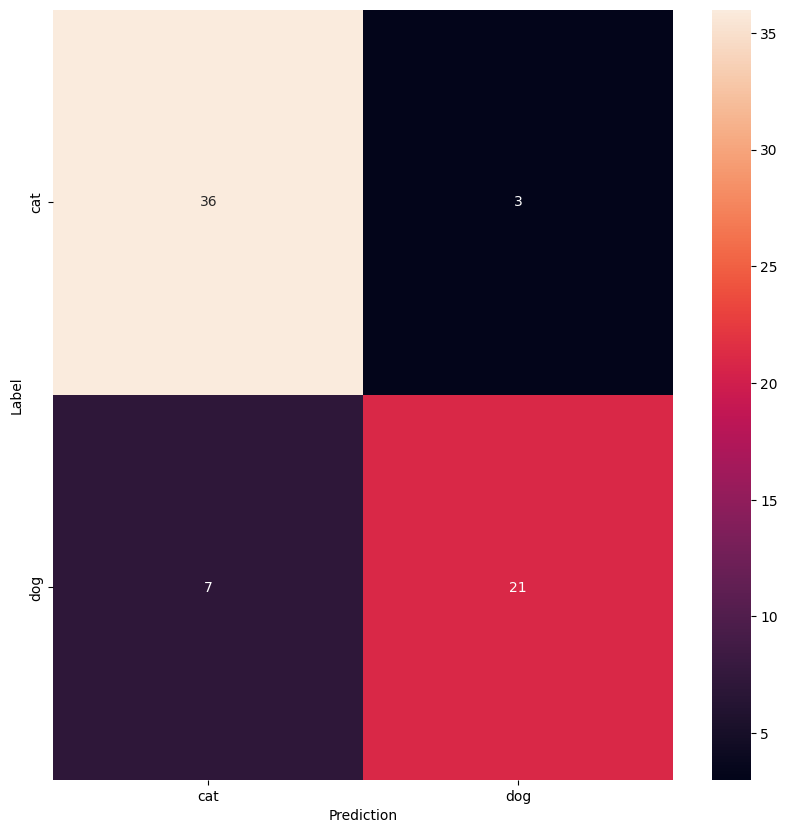

In [280]:
conf_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
seaborn.heatmap(conf_mtx, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()